## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

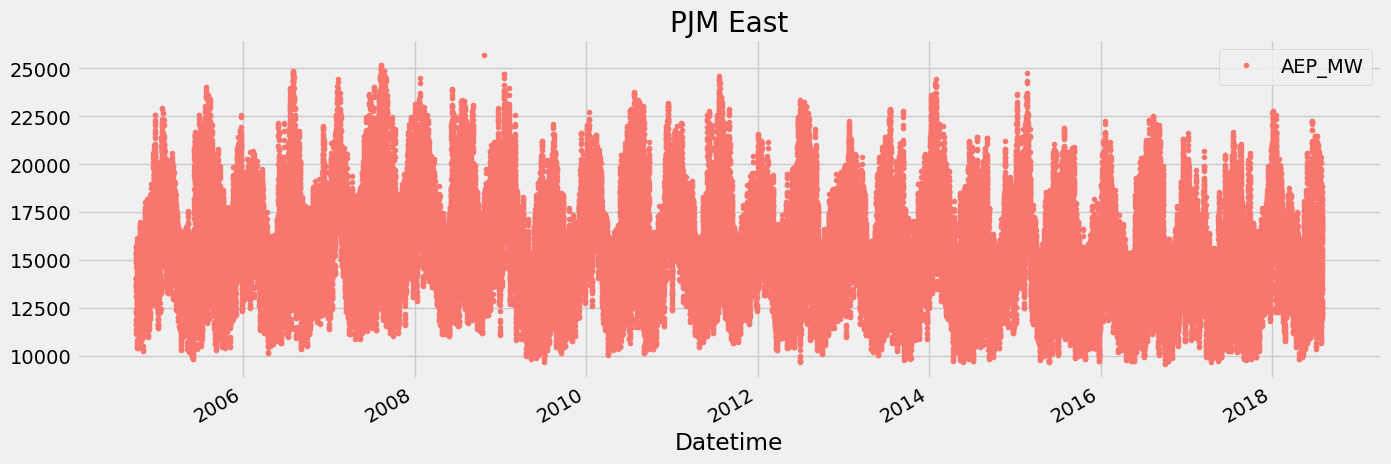

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


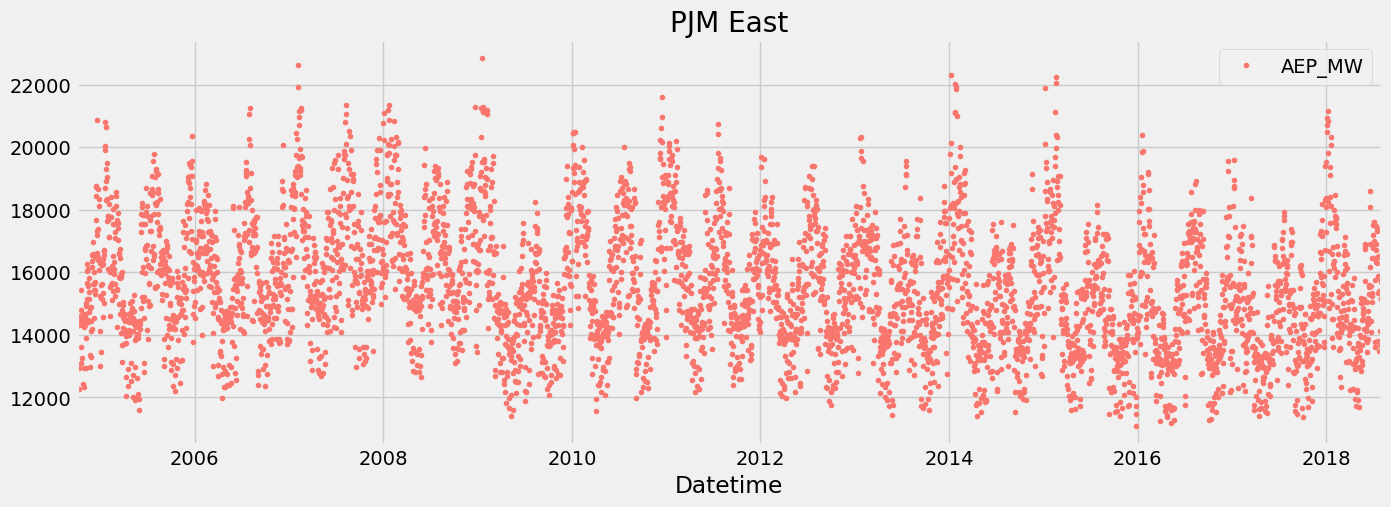

In [4]:
pjme = pjme.sort_index()    # 时间序列回归问题务必先排序
pjme = pjme.resample('D').mean()    # 降采样为每天数据，增加数据粒度，减轻VARMAX模型训练成本
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [5]:
pjme.head()

,AEP_MW
Datetime,
2004-10-01,14284.521739
2004-10-02,12999.875000
2004-10-03,12227.083333
2004-10-04,14309.041667
2004-10-05,14439.708333


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [6]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

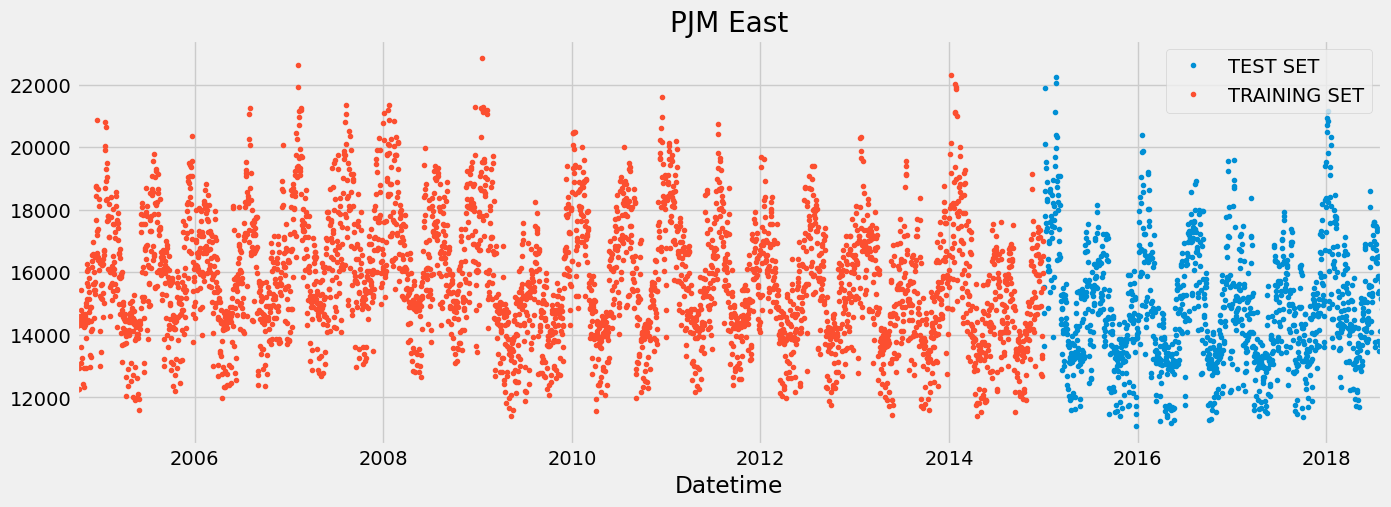

In [7]:
_ = pjme_test.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Values

In [8]:
train_data = pjme_train
test_data = pjme_test

In [9]:
train_data.head(100)

,AEP_MW
Datetime,
2004-10-01,14284.521739
2004-10-02,12999.875000
2004-10-03,12227.083333
2004-10-04,14309.041667
2004-10-05,14439.708333
...,...
2005-01-04,15583.458333
2005-01-05,16226.875000
2005-01-06,15618.791667


In [10]:
# 需要降采样至1天, 采用小时为粒度会过多消耗内存
order = (7, 1, 7)  # (自回归阶数p, 差分阶数d, 移动平均阶数q)
seasonal_order = (7, 1, 7, 14) # (季节性自回归阶数P, 季节性差分阶数D, 季节性移动平均阶数Q, 季节性周期长度S(7天数据可以设置为7))
reg = SARIMAX(train_data['AEP_MW'], order=order, seasonal_order=seasonal_order)
reg_fit = reg.fit(disp=False)

D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecast on Test Set

In [11]:
predictions = reg_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

In [12]:
# SARMAX 模型可能会消耗大量内存，尤其是在处理多变量时间序列时。以下是解决 MemoryError 的几种方法：
# 1)减少数据量; 2)减少特征数量
pjme_test['MW_Prediction'] = predictions.to_numpy()
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

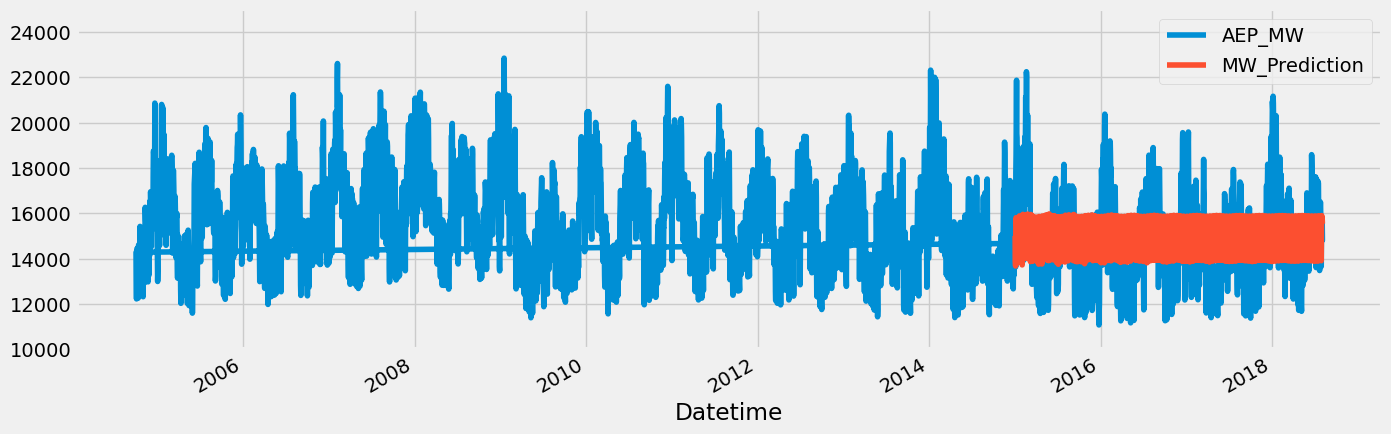

In [13]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5), ylim=(10000, 25000))

## Look at first month of predictions

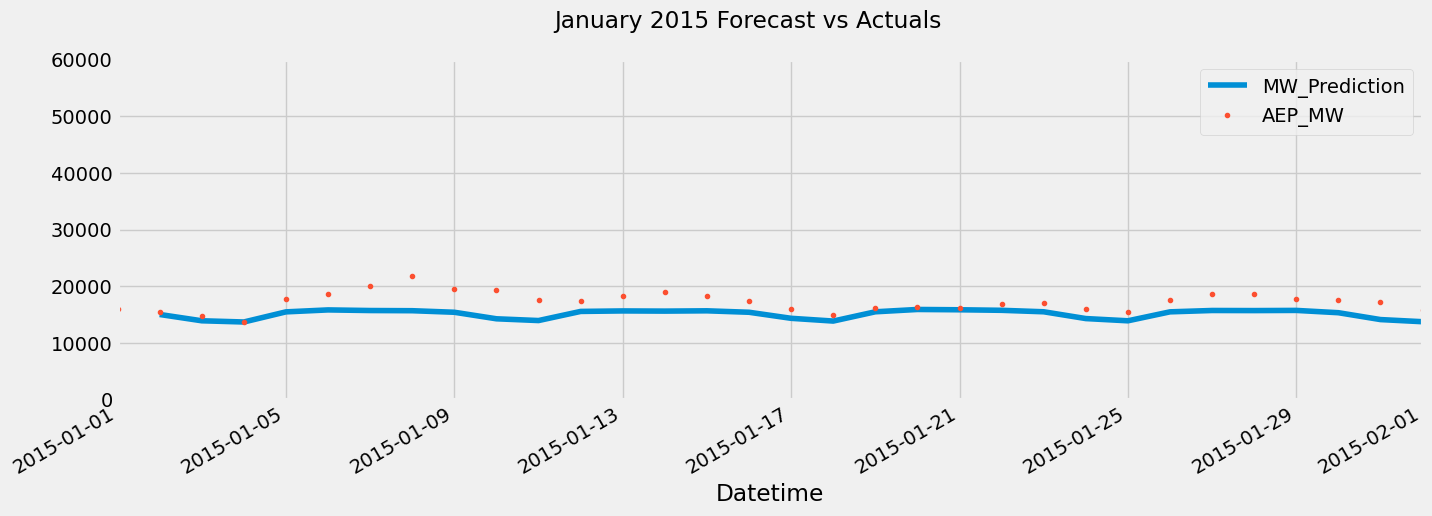

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

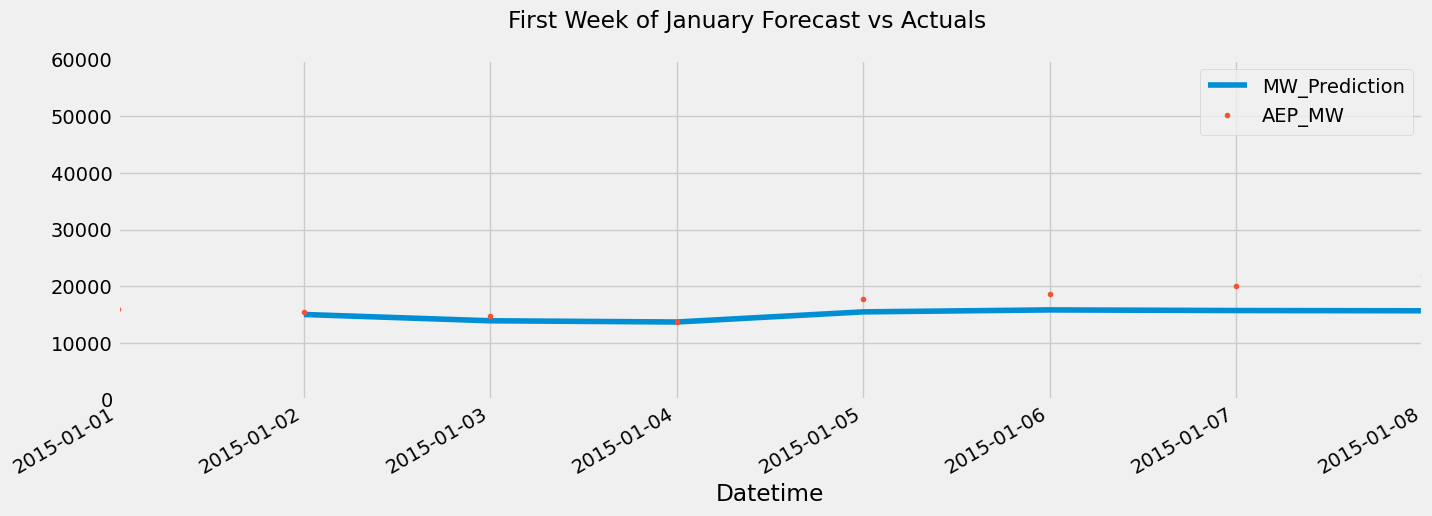

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

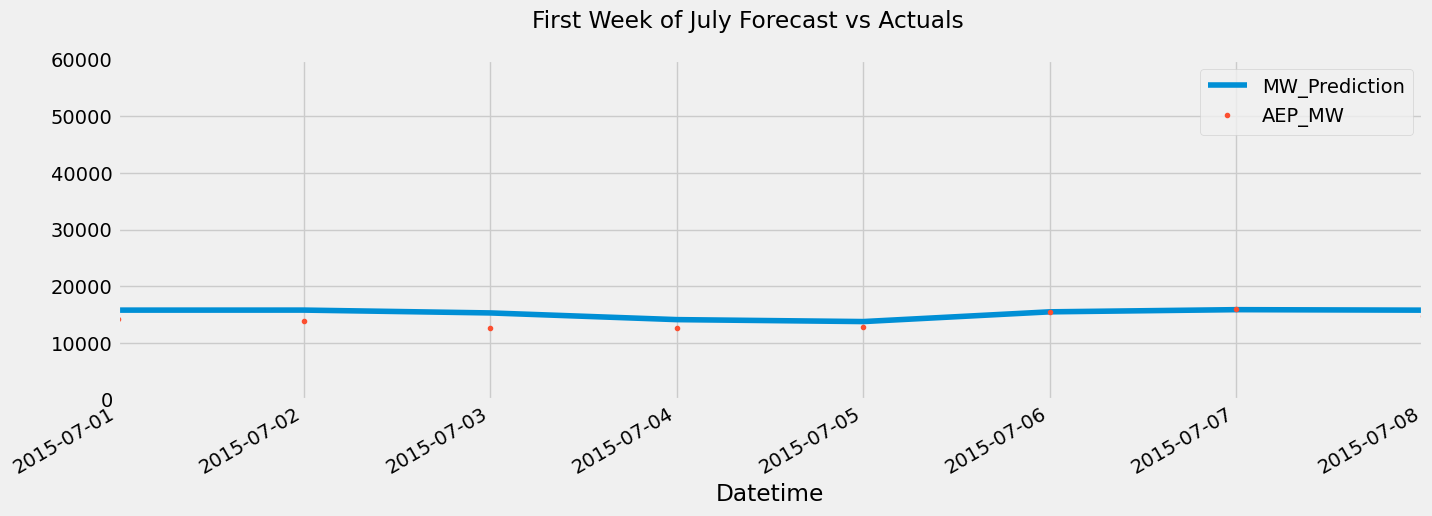

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [17]:
mean_squared_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

3396605.2376753115

In [18]:
mean_absolute_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

1528.1334353222003

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

10.531256912443975

## Look at Worst and Best Predicted Days

In [22]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['Datetime']).mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [23]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

,AEP_MW,MW_Prediction,error,abs_error
Datetime,,,,
2015-12-25,11078.041667,15488.449527,-4410.407860,4410.407860
2015-12-24,11466.041667,15703.300325,-4237.258658,4237.258658
2018-04-24,11723.750000,15900.143498,-4176.393498,4176.393498
2015-11-26,11718.500000,15831.967789,-4113.467789,4113.467789
2015-11-27,11755.083333,15601.981102,-3846.897769,3846.897769
2016-11-24,12148.750000,15803.984535,-3655.234535,3655.234535
2016-07-04,12048.000000,15509.298223,-3461.298223,3461.298223
2017-04-14,12194.541667,15504.448972,-3309.907306,3309.907306
2016-12-26,12242.375000,15539.099335,-3296.724335,3296.724335


Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [24]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

,AEP_MW,MW_Prediction,error,abs_error
Datetime,,,,
2018-01-06,20847.833333,14330.225133,6517.608200,6517.608200
2015-02-19,22249.500000,15853.557024,6395.942976,6395.942976
2015-02-20,22047.041667,15652.647879,6394.393787,6394.393787
2015-01-08,21873.333333,15669.590348,6203.742986,6203.742986
2018-01-07,19803.375000,13927.525783,5875.849217,5875.849217
2015-02-15,19695.958333,14019.261380,5676.696953,5676.696953
2018-01-05,21166.833333,15510.068182,5656.765151,5656.765151
2015-02-16,21129.791667,15587.772079,5542.019587,5542.019587
2015-01-10,19343.208333,14242.998688,5100.209646,5100.209646


The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [25]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

,AEP_MW,MW_Prediction,error,abs_error
Datetime,,,,
2017-03-05,13922.000000,13921.540573,0.459427,0.459427
2015-11-22,13986.125000,13984.354136,1.770864,1.770864
2018-03-05,15552.958333,15560.650366,-7.692032,7.692032
2018-04-17,15802.166667,15793.434443,8.732224,8.732224
2016-09-19,15531.625000,15541.931578,-10.306578,10.306578
2017-07-06,15727.000000,15738.412072,-11.412072,11.412072
2016-11-22,15896.333333,15907.973003,-11.639670,11.639670
2015-05-30,14421.458333,14434.224212,-12.765879,12.765879
2018-03-16,15506.208333,15521.595405,-15.387072,15.387072


Plotting some best/worst predicted days

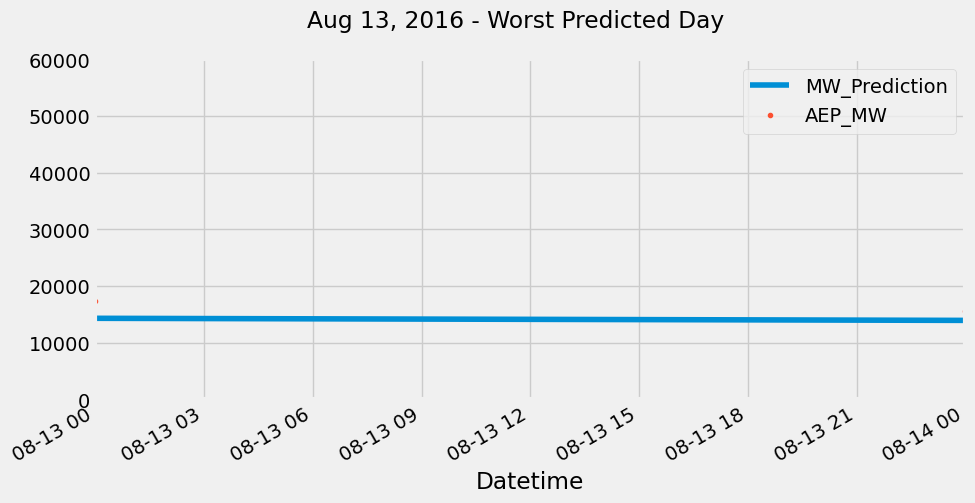

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

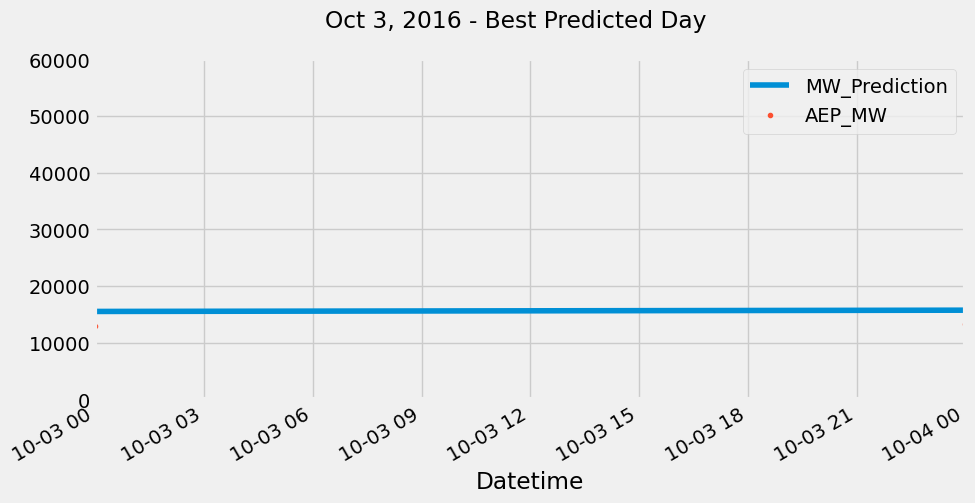

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

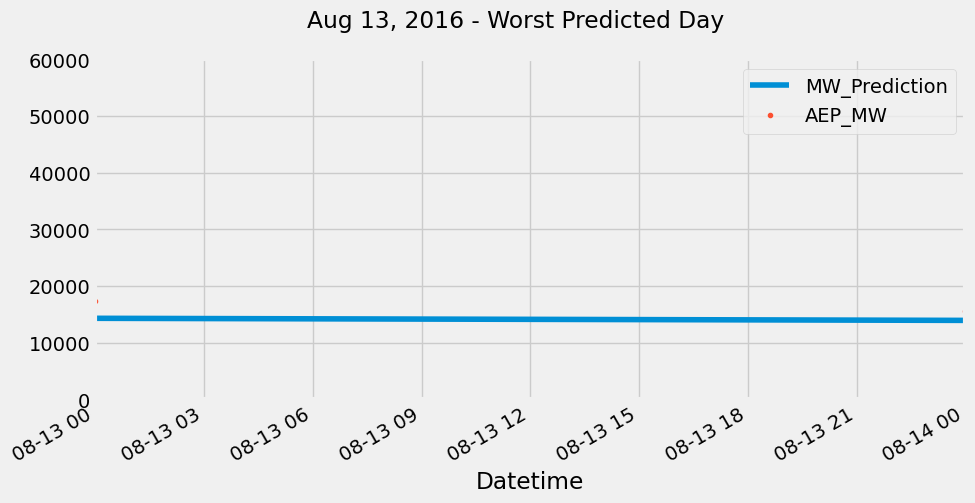

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>
<li>Add other data source empirically correlated to time.</li>